In [1]:
import os
from pathlib import Path
import logging
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import hamming_loss, make_scorer

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass
from capstone.features import Features
from capstone.evaluation import CustomEvaluation
from capstone.utils.constants import (
    TEXT,
    TARGET,
    SPLIT,
    DEVELOP,
    TEST
)

sns.set_style("darkgrid")
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

In [2]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(3)

,Text,Standard mapping?
0,General Quality System Requirements […] Manage...,"[quality management, quality planning]"
1,General Quality System Requirements […] Manage...,[quality management]
2,General Quality System Requirements […] Manage...,[quality management]


In [3]:
features = Features(config)
df_features = features.build(df)

2022-11-14 06:28:01,621 - capstone.utils.utils - INFO - func:clean took: 3.09 sec
2022-11-14 06:28:02,288 - capstone.utils.utils - INFO - func:fit took: 3.75 sec
2022-11-14 06:28:03,969 - capstone.utils.utils - INFO - func:clean took: 1.68 sec
2022-11-14 06:28:04,200 - capstone.utils.utils - INFO - func:transform took: 1.91 sec
2022-11-14 06:28:04,201 - capstone.utils.utils - INFO - func:fit_transform took: 5.67 sec
2022-11-14 06:28:04,386 - capstone.utils.utils - INFO - func:clean took: 0.18 sec
2022-11-14 06:28:04,413 - capstone.utils.utils - INFO - func:transform took: 0.21 sec
2022-11-14 06:28:04,445 - capstone.utils.utils - INFO - func:build took: 5.93 sec


In [4]:
df_features.head(3)

,Text,Standard mapping?,Original Text,audit inspection,calibration,capa,change controls,clinical research,controled substances,csv,...,word__unit generally,word__unit generally shared,word__use device,word__used manufacture,word__used production,word__validation study,word__way ensures,word__wholesale distributor,word__written procedure,Split
0,good practice quality control qc responsibilit...,"[laboratory controls, stability programs]",Good practices in quality control […] Other QC...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.439675,Development
1,good practice quality control basic requiremen...,"[capa, nc, rca]",Good practices in quality control […] The basi...,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,Development
2,validation process validation program critical...,[process & packaging validation],Validation […] Process Validation Program […] ...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.285952,0.0,0.0,0.000000,Development


Feature Length

In [5]:
print(f"Length of features: {len(features.vectorizer.get_feature_names_out())}")

Length of features: 507


In [6]:
dev = df_features[df_features[SPLIT].isin([DEVELOP])].copy()
X_dev = dev[features.vectorizer.get_feature_names_out()].copy()
Y_dev = dev[features.mlb.classes_].copy()

test = df_features[df_features[SPLIT].isin([TEST])].copy()
X_test = test[features.vectorizer.get_feature_names_out()].copy()
Y_test = test[features.mlb.classes_].copy()

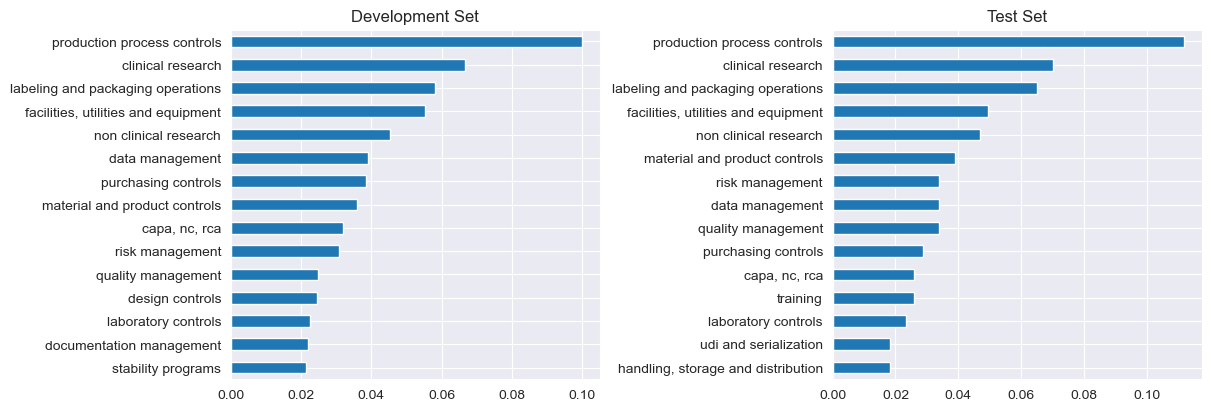

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

dev[TARGET] \
.apply(lambda x: ", ".join(sorted(x))) \
.value_counts(normalize=True) \
.head(15) \
.sort_values() \
.plot(kind="barh", ax=ax[0])

test[TARGET] \
.apply(lambda x: ", ".join(sorted(x))) \
.value_counts(normalize=True) \
.head(15) \
.sort_values() \
.plot(kind="barh", ax=ax[1])

ax[0].set_title("Development Set")
ax[1].set_title("Test Set")
plt.show();

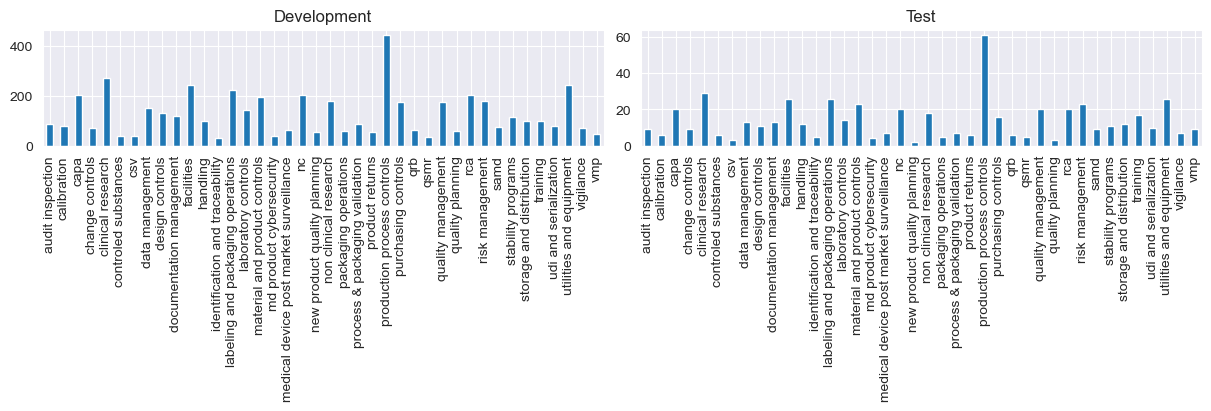

In [8]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
Y_dev.sum(axis=0).plot.bar(ax=ax[0])
Y_test.sum(axis=0).plot.bar(ax=ax[1])
ax[0].set_title("Development")
ax[1].set_title("Test");

In [9]:
eval = CustomEvaluation()
score = make_scorer(eval.hamming_loss, greater_is_better=False)

In [10]:
params = {
    'estimator__n_estimators': [i for i in range(50, 225, 25)],
    'estimator__max_depth': [10, 20, 30, 40, 50],
    'estimator__max_features': ["sqrt", "log2"],
    "estimator__class_weight": ["balanced_subsample"]
}
rf_classifier = MultiOutputClassifier(RandomForestClassifier())

# ratios = dev.shape[0] / dev[features.mlb.classes_].sum(axis=0)
# ratios = round(ratios).astype(int)
# weights = [{0: 1, 1: ratios[i]} for i in range(len(features.mlb.classes_))]

clf = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=params,
    scoring=score,
    cv=5,
    return_train_score=False,
    verbose=10
)

clf.fit(X_dev, Y_dev)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START estimator__class_weight=balanced_subsample, estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=200
[CV 1/5; 1/10] END estimator__class_weight=balanced_subsample, estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=200;, score=-0.030 total time=  26.3s
[CV 2/5; 1/10] START estimator__class_weight=balanced_subsample, estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=200
[CV 2/5; 1/10] END estimator__class_weight=balanced_subsample, estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=200;, score=-0.037 total time=  27.5s
[CV 3/5; 1/10] START estimator__class_weight=balanced_subsample, estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=200
[CV 3/5; 1/10] END estimator__class_weight=balanced_subsample, estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_esti

RandomizedSearchCV(cv=5,
                   estimator=MultiOutputClassifier(estimator=RandomForestClassifier()),
                   param_distributions={'estimator__class_weight': ['balanced_subsample'],
                                        'estimator__max_depth': [10, 20, 30, 40,
                                                                 50],
                                        'estimator__max_features': ['sqrt',
                                                                    'log2'],
                                        'estimator__n_estimators': [50, 75, 100,
                                                                    125, 150,
                                                                    175, 200]},
                   scoring=make_scorer(hamming_loss, greater_is_better=False),
                   verbose=10)

In [11]:
### Random search over a bigger space -- don't run
# params = {
#     'estimator__n_estimators': [i for i in range(50, 250, 25)],
#     "estimator__criterion": ["gini", "entropy", "log_loss"],
#     'estimator__max_depth': [10, 20, 30, 40, 50],
#     'estimator__max_features': ["sqrt", "log2"],
#     "estimator__class_weight": ["balanced_subsample", "balanced"],
#     "estimator__max_samples": [.6, .7, 1.0]
# }
# rf_classifier = MultiOutputClassifier(RandomForestClassifier())

# # ratios = dev.shape[0] / dev[features.mlb.classes_].sum(axis=0)
# # ratios = round(ratios).astype(int)
# # weights = [{0: 1, 1: ratios[i]} for i in range(len(features.mlb.classes_))]

# clf = RandomizedSearchCV(
#     estimator=rf_classifier,
#     param_distributions=params,
#     n_iter=100,
#     scoring=score,
#     cv=5,
#     return_train_score=False,
#     verbose=10,
#     n_jobs=6
# )

# clf.fit(X_dev, Y_dev)

In [12]:
clf.best_estimator_.get_params()

{'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': 'balanced_subsample',
 'estimator__criterion': 'gini',
 'estimator__max_depth': 20,
 'estimator__max_features': 'sqrt',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 125,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                        n_estimators=125),
 'n_jobs': None}

In [13]:
feature_importances = []

for forest in clf.best_estimator_.estimators_:
    feature_importances.append(forest.feature_importances_)

feature_importances = np.mean(feature_importances, axis=0)

scores_, labels_ = map(
    list,
    zip(*sorted(
        list(zip(feature_importances, features.vectorizer.get_feature_names_out())),
        key=lambda x: x[0],
        reverse=True
    ))
)
labels_ = [x.split("__")[1] for x in labels_]

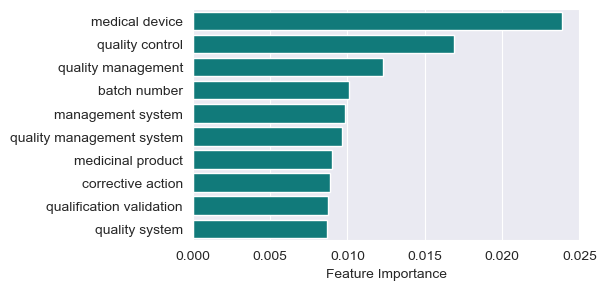

In [14]:
plt.figure(figsize=(5,3))
sns.barplot(x=scores_[:10], y=labels_[:10], color="darkcyan")
plt.xlabel("Feature Importance")
plt.show();

In [15]:
rf_dev_pred = clf.best_estimator_.predict(X_dev)
rf_test_pred = clf.best_estimator_.predict(X_test)

print(f"Random Forest Development Hamming Loss: {eval.hamming_loss(Y_dev, rf_dev_pred):.5f}")
print(f"Random Forest Test Hamming Loss: {eval.hamming_loss(Y_test, rf_test_pred):.5f}")

Random Forest Development Hamming Loss: 0.01538
Random Forest Test Hamming Loss: 0.03249


Evaluation (Sample metrics) - Test Set

In [16]:
eval.compute_sample_wise_metrics(y_true=Y_test.to_numpy(), y_pred=rf_test_pred)

Hamming Loss    0.032487
Accuracy        0.359375
Precision       0.510851
Recall          0.551128
F1 Score        0.506135
F2 Score        0.525464
dtype: float64

Evaluation (Label metrics) - Test Set

In [17]:
cmat = eval.compute_multilabel_confusion_matrix(
    y_true=Y_test.to_numpy(), y_pred=rf_test_pred, labels=features.mlb.classes_
)
cmat.style.set_table_styles(config.CONFUSION_MATRIX_STYLER)

/Users/vishweshwartyagi/JJPROJ/JNJ-Capstone-Project/src/capstone/capstone/evaluation/evaluation.py:76: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  multi_confusion_matirx = multilabel_confusion_matrix(y_true, y_pred)
/Users/vishweshwartyagi/JJPROJ/JNJ-Capstone-Project/src/capstone/capstone/evaluation/evaluation.py:76: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='columns')`
  multi_confusion_matirx = multilabel_confusion_matrix(y_true, y_pred)
/Users/vishweshwartyagi/JJPROJ/JNJ-Capstone-Project/src/capstone/capstone/evaluation/evaluation.py:85: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  ) for x in multi_confusion_matirx]],
/Users/vishweshwartyagi/JJPROJ/JNJ-Capstone-Project/src/capstone/capstone/evaluation/evaluation.py:85: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='columns')`
  ) for x in multi_confusion_matirx]],


In [18]:
eval.compute_label_wise_metrics(
    y_true=Y_test.to_numpy(),
    y_pred=rf_test_pred,
    labels=features.mlb.classes_,
    dev_samples=Y_dev.to_numpy().sum(axis=0).tolist()
)

,Precision,Recall,F1 Score,F2 Score,Development Samples,Test Samples
audit inspection,1.000000,0.444444,0.615385,0.500000,86,9
calibration,1.000000,0.333333,0.500000,0.384615,78,6
capa,0.714286,0.250000,0.370370,0.287356,202,20
change controls,1.000000,0.222222,0.363636,0.263158,71,9
clinical research,0.750000,0.620690,0.679245,0.642857,269,29
controled substances,0.053571,1.000000,0.101695,0.220588,40,6
csv,0.000000,0.000000,0.000000,0.000000,37,3
data management,0.642857,0.692308,0.666667,0.681818,150,13
design controls,0.777778,0.636364,0.700000,0.660377,132,11
documentation management,0.500000,0.230769,0.315789,0.258621,117,13


In [19]:
svc = MultiOutputClassifier(LinearSVC(class_weight="balanced", C=0.5, max_iter=5000))
svc.fit(X_dev, Y_dev)


MultiOutputClassifier(estimator=LinearSVC(C=0.5, class_weight='balanced',
                                          max_iter=5000))

In [20]:
svc_dev_pred = svc.predict(X_dev)
svc_test_pred = svc.predict(X_test)

print(f"SVC Development Hamming Loss: {hamming_loss(Y_dev, svc_dev_pred):.5f}")
print(f"SVC Test Hamming Loss: {hamming_loss(Y_test, svc_test_pred):.5f}")

SVC Development Hamming Loss: 0.05611
SVC Test Hamming Loss: 0.07194


Evaluation (Sample metrics) - Test Set

In [21]:
eval.compute_sample_wise_metrics(y_true=Y_test.to_numpy(), y_pred=svc_test_pred)

Hamming Loss    0.071940
Accuracy        0.169271
Precision       0.410367
Recall          0.774792
F1 Score        0.491258
F2 Score        0.602439
dtype: float64

Evaluation (Label metrics) - Test Set

In [22]:
cmat = eval.compute_multilabel_confusion_matrix(
    y_true=Y_test.to_numpy(), y_pred=svc_test_pred, labels=features.mlb.classes_
)
cmat.style.set_table_styles(config.CONFUSION_MATRIX_STYLER)

/Users/vishweshwartyagi/JJPROJ/JNJ-Capstone-Project/src/capstone/capstone/evaluation/evaluation.py:76: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  multi_confusion_matirx = multilabel_confusion_matrix(y_true, y_pred)
/Users/vishweshwartyagi/JJPROJ/JNJ-Capstone-Project/src/capstone/capstone/evaluation/evaluation.py:76: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='columns')`
  multi_confusion_matirx = multilabel_confusion_matrix(y_true, y_pred)
/Users/vishweshwartyagi/JJPROJ/JNJ-Capstone-Project/src/capstone/capstone/evaluation/evaluation.py:85: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  ) for x in multi_confusion_matirx]],
/Users/vishweshwartyagi/JJPROJ/JNJ-Capstone-Project/src/capstone/capstone/evaluation/evaluation.py:85: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='columns')`
  ) for x in multi_confusion_matirx]],


In [23]:
eval.compute_label_wise_metrics(
    y_true=Y_test.to_numpy(),
    y_pred=svc_test_pred,
    labels=features.mlb.classes_,
    dev_samples=Y_dev.to_numpy().sum(axis=0).tolist()
)

,Precision,Recall,F1 Score,F2 Score,Development Samples,Test Samples
audit inspection,0.368421,0.777778,0.500000,0.636364,86,9
calibration,0.173913,0.666667,0.275862,0.425532,78,6
capa,0.208333,0.500000,0.294118,0.390625,202,20
change controls,0.240000,0.666667,0.352941,0.491803,71,9
clinical research,0.558824,0.655172,0.603175,0.633333,269,29
controled substances,0.109091,1.000000,0.196721,0.379747,40,6
csv,0.166667,0.666667,0.266667,0.416667,37,3
data management,0.392857,0.846154,0.536585,0.687500,150,13
design controls,0.360000,0.818182,0.500000,0.652174,132,11
documentation management,0.111111,0.692308,0.191489,0.338346,117,13


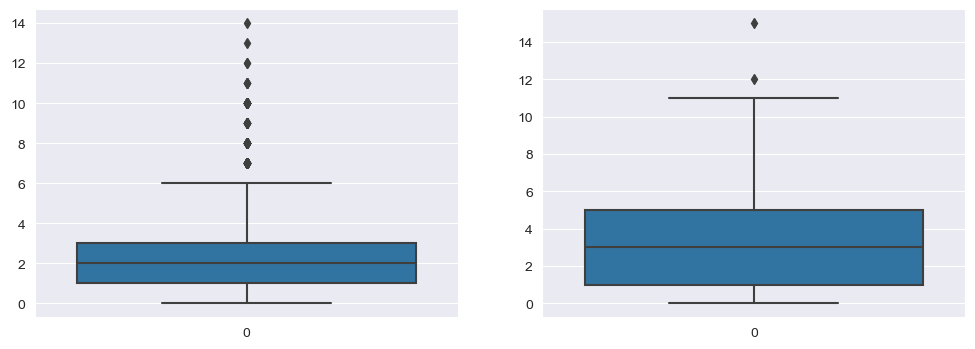

In [24]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot((svc_dev_pred != Y_dev.to_numpy().astype(int)).sum(axis=1), ax=ax[0])
sns.boxplot((svc_test_pred != Y_test.to_numpy().astype(int)).sum(axis=1), ax=ax[1])
ax[0].set_label("SVC Performance - Development Set")
ax[1].set_label("SVC Performance - Test Set")

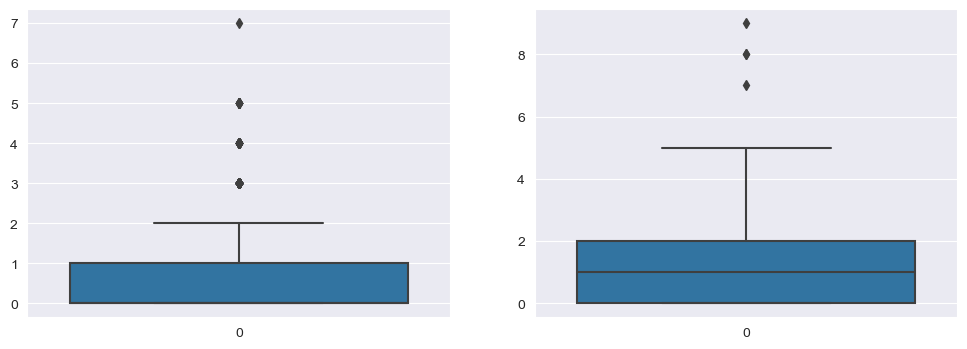

In [25]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot((rf_dev_pred != Y_dev.to_numpy().astype(int)).sum(axis=1), ax=ax[0])
sns.boxplot((rf_test_pred != Y_test.to_numpy().astype(int)).sum(axis=1), ax=ax[1])
ax[0].set_label("Random Forest Performance - Development Set")
ax[1].set_label("Random Fores Performance - Test Set")

Other evaluation metrics.

Example-based
1. Hamming loss: computes the proportion of incorrectly predicted labels to the total number of labels. For a multilabel classification, we compute the number of False Positives and False Negative per instance and then average it over the total number of training instances.
2. Exact Match Ratio (EMR): An extension of single label classification accuracy. The drawback is that it does not account for partially correct labels.
3. Example-Based Accuracy & Precision: The proportion of predicted correct labels to the total number of predicted labels, averaged over all instances.


In [26]:
N_example, N_class = rf_test_pred.shape

In [27]:
#Exact Match Ratio (EMR) is just accuracy

In [28]:
#Example-Based Accuracy Precision
print('Example-Based Accuracy Precision: ', np.mean(np.sum(rf_test_pred == Y_test.to_numpy().astype(int), axis=1)/N_class))


Example-Based Accuracy Precision:  0.9675130208333332


Label based evaluation metrics:

1. Macro Averaged Accuracy Precision Recall: calcu- late on individual class label and then averaged over all classes.
2. Micro Averaged Accuracy Precision Recall: calculate globally over all instances and all class labels.

In [29]:
#Precision = TruePositives / (TruePositives + FalsePositives) 
#Recall = TruePositives / (TruePositives + FalseNegatives) 

In [30]:
def TP_FP_FN(p,y):
    #by class
    TP_list = []
    FP_list = []
    FN_list = []
    for j in range(len(p[0])):
        TP,FP,FN = 0,0,0
        for i in range(len(p)):
            if y[i][j]==1 and p[i][j]==1:
                TP += 1
            if y[i][j]==0 and p[i][j]==1:
                FP += 1
            if y[i][j]==1 and p[i][j]==0:
                FN += 1
        TP_list.append(TP)
        FP_list.append(FP)
        FN_list.append(FN)
    return np.array(TP_list),np.array(FP_list),np.array(FN_list)

TP_list,FP_list,FN_list = TP_FP_FN(rf_test_pred, Y_test.to_numpy().astype(int))

In [31]:
# average over all classes
# Macro_precision
# warning message comes from denominator being 0 for some classes
# use np.nanmean to exclude those cases when computing average over classes
print("Random Forest Label based Macro precision: ", np.nanmean(TP_list/(TP_list+FP_list)))
# Macro_recall
print("Random Forest Label based Macro recall: ", np.nanmean(TP_list/(TP_list+FN_list)))
# Question: low recall, high False Negatives

Random Forest Label based Macro precision:  0.6696437476199231
Random Forest Label based Macro recall:  0.44383394453904945


In [32]:
# globally over all data points
# Micro_precision
print("Random Forest Global Micro precision: ",sum(TP_list)/(sum(TP_list+FP_list)))
# Micro_recall
print("Random Forest Global Micro recall: ", sum(TP_list)/(sum(TP_list+FN_list)))


Random Forest Global Micro precision:  0.5523012552301255
Random Forest Global Micro recall:  0.4808743169398907


In [33]:
TP_list, FP_list, FN_list = TP_FP_FN(svc_test_pred, Y_test.to_numpy().astype(int))
# average over all classes
# Macro_precision
# warning message comes from denominator being 0 for some classes
# use np.nanmean to exclude those cases when computing average over classes
print("SVC Label based Macro precision: ", np.nanmean(TP_list/(TP_list+FP_list)))
# Macro_recall
print("SVC Label based Macro recall: ", np.nanmean(TP_list/(TP_list+FN_list)))
# Question: low recall, high False Negatives
# globally over all data points
# Micro_precision
print("SVC Global Micro precision: ",sum(TP_list)/(sum(TP_list+FP_list)))
# Micro_recall
print("SVC Global Micro recall: ", sum(TP_list)/(sum(TP_list+FN_list)))


SVC Label based Macro precision:  0.3023235450304392
SVC Label based Macro recall:  0.7493323475758825
SVC Global Micro precision:  0.2964860907759883
SVC Global Micro recall:  0.7377049180327869
